# Implementation of DNN from scratch using numpy

This notebook is inspired by Coursera Deep Learning Course 1 assignment on writing Dense Neural Network from scratch using numpy.

I wrote this as an exercise to see if I could implement multiple layers of DNNs by writing forward propagation and backward propagation functions and by using a cache for each layer to store parameter, input and output data necessary for backpropagation calculations.

Just like the notebook in Andrew NG's assignment, I tested the L-layer Neural Network by using a cat/non-cat dataset to see how well it performs binary classification.

I also use the same L-layer DNN code to classify datapoints with nonlinear classification boundaries and it works pretty well!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import h5py
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline
# plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
# plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def load_data():
    train_dataset = h5py.File('train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [4]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

print(train_x_orig.shape)

(209, 64, 64, 3)


y = 1. It's a cat picture.


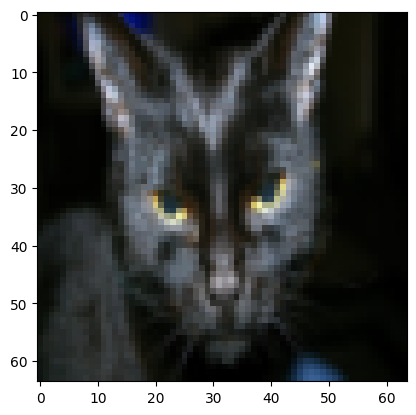

In [5]:
# Example of a picture
index = 25
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [6]:
# Explore your dataset
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [7]:
# Reshape the training and test examples
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255
test_x = test_x_flatten/255

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


In [8]:
# Constants
n_x = 12288
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [9]:
def sigmoid(Z):
    A = 1 / (1 + np.exp(-Z))
    cache = Z
    return A, cache

def relu(Z):
    A = np.maximum(0, Z)
    cache = Z
    return A, cache

In [10]:
def sigmoid_backward(dA, cache):
    Z = cache

    a, _ = sigmoid(Z)

    dZ = dA * a * (1 - a)

    return dZ

def relu_backward(dA, cache):
    Z = cache

    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0

    return dZ

In [11]:
def initialize_weights(layer_dims):

    weights = {}
    L = len(layer_dims)

    for l in range(1,L):
        weights['W'+str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) # * 0.01 # The initialization with * 0.01 doesnt seem to converge for cat classification, but / np.sqrt() does very quickly
        weights['b'+str(l)] = np.zeros((layer_dims[l],1))
        # weights['b'+str(l)] = np.random.randn(layer_dims[l],1) # random initialization on biases, not used for now

    return weights


In [12]:
def forward_linear(A, W, b):

    Z = np.matmul(W, A) + b
    cache = (A, W, b)

    return Z, cache

In [13]:
def forward_activation(A_prev, W, b, activation):

    Z, linear_cache = forward_linear(A_prev, W, b)

    if activation == 'relu':
        A, activation_cache = relu(Z)
    elif activation == 'sigmoid':
        A, activation_cache = sigmoid(Z)

    cache = (linear_cache, activation_cache)

    return A, cache

In [14]:
def forward_propagation(X, weights):
    caches = []
    A = X
    L = len(weights) // 2 # number of layers in the neural network

    for l in range(1,L):
        A_prev = A
        A, cache = forward_activation(A_prev, weights['W'+str(l)], weights['b'+str(l)], 'relu')
        caches.append(cache)

    AL, cache = forward_activation(A, weights['W'+str(L)], weights['b'+str(L)], 'sigmoid')
    caches.append(cache)

    return AL, caches

In [15]:
def compute_cost(AL, Y):
    m = Y.shape[1]

    cost = (-1./m) * (np.dot(Y, np.log(AL).T) + np.dot((1-Y), np.log(1-AL).T))

    cost = np.squeeze(cost) # converts something like [[17]] to 17, i.e, a scalar

    return cost

In [16]:
def linear_backward(dZ, cache):

    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1./m) * np.matmul(dZ, A_prev.T)
    db = (1./m) * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.matmul(W.T, dZ)

    return dA_prev, dW, db

In [17]:
def activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache

    if activation == 'relu':
        dZ = relu_backward(dA, activation_cache)
    elif activation == 'sigmoid':
        dZ = sigmoid_backward(dA, activation_cache)

    dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db

In [18]:
def backward_propagation(AL, Y, caches):
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL

    dAL = -(np.divide(Y, AL) - np.divide(1-Y,1-AL))

    current_cache = caches[L-1] # last layer

    grads['dA'+str(L-1)], grads['dW'+str(L)], grads['db'+str(L)] = activation_backward(dAL, current_cache, 'sigmoid')

    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = activation_backward(grads['dA'+str(l+1)], current_cache, 'relu')
        grads['dA'+str(l)] = dA_prev_temp
        grads['dW'+str(l+1)] = dW_temp
        grads['db'+str(l+1)] = db_temp

    return grads

In [19]:
def update_weights(weights, grads, learning_rate):
    L = len(weights) // 2
    for l in range(L):
        weights['W'+str(l+1)] = weights['W'+str(l+1)] - learning_rate * grads['dW'+str(l+1)]
        weights['b'+str(l+1)] = weights['b'+str(l+1)] - learning_rate * grads['db'+str(l+1)]

    return weights


In [20]:
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.

    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model

    Returns:
    p -- predictions for the given dataset X
    """

    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))

    # Forward propagation
    probas, caches = forward_propagation(X, parameters)


    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p == y)/m)))

    return p

In [21]:
def print_mislabeled_images(classes, X, y, p):
    """
    Plots images where predictions and truth were different.
    X -- dataset
    y -- true labels
    p -- predictions
    """
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]

        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))

In [22]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost = True): # lr was 0.009

    costs = []
    weights = initialize_weights(layers_dims)

    for i in range(0, num_iterations):

        AL, caches = forward_propagation(X, weights)

        cost = compute_cost(AL, Y)

        grads = backward_propagation(AL, Y, caches)

        weights = update_weights(weights, grads, learning_rate)

        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 1 == 0:
            costs.append(cost)

            # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    return weights


Cost after iteration 0: 0.699159
Cost after iteration 100: 0.531442
Cost after iteration 200: 0.465305
Cost after iteration 300: 0.412994
Cost after iteration 400: 0.357319
Cost after iteration 500: 0.311678
Cost after iteration 600: 0.271627
Cost after iteration 700: 0.213715
Cost after iteration 800: 0.180367
Cost after iteration 900: 0.151128
Cost after iteration 1000: 0.107356
Cost after iteration 1100: 0.089816
Cost after iteration 1200: 0.075231
Cost after iteration 1300: 0.062728
Cost after iteration 1400: 0.054149
Cost after iteration 1500: 0.047374
Cost after iteration 1600: 0.042291
Cost after iteration 1700: 0.037984
Cost after iteration 1800: 0.034427
Cost after iteration 1900: 0.031367
Cost after iteration 2000: 0.028831
Cost after iteration 2100: 0.026585
Cost after iteration 2200: 0.024639
Cost after iteration 2300: 0.022998
Cost after iteration 2400: 0.021521


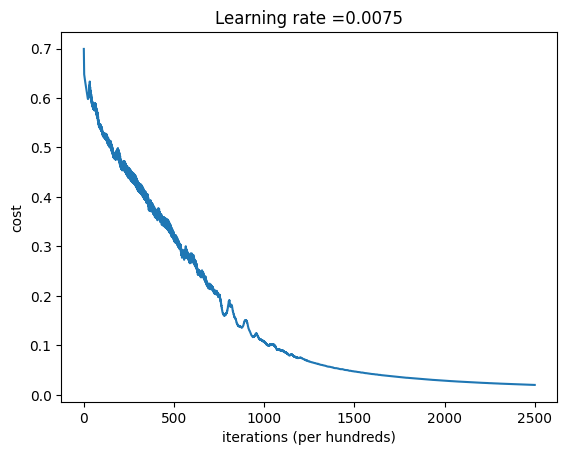

In [23]:
weights = L_layer_model(train_x, train_y, layers_dims, learning_rate = 0.0075, num_iterations = 2500, print_cost = True)

In [24]:
print(classes)

[b'non-cat' b'cat']


Accuracy: 0.9999999999999998
Accuracy: 0.74


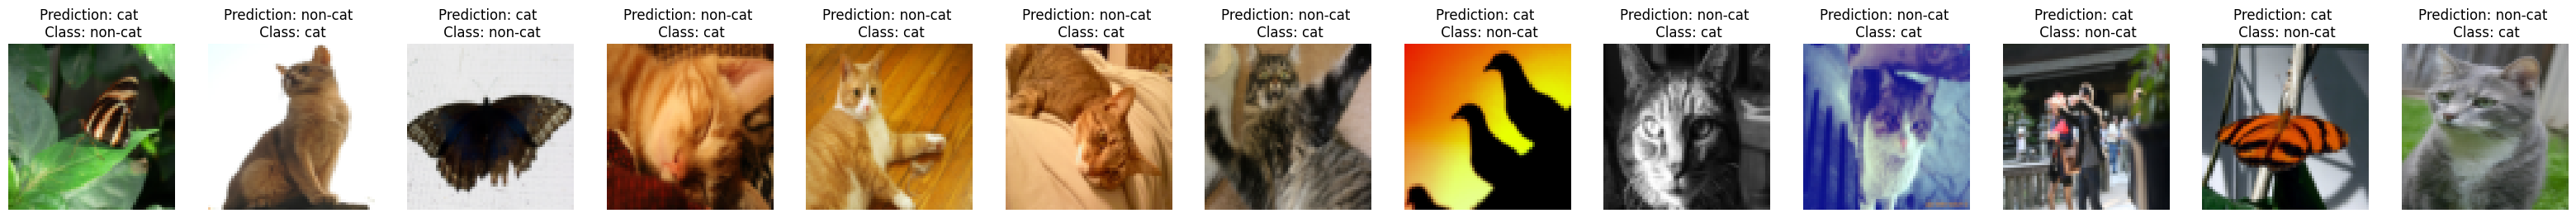

In [25]:
pred_train = predict(train_x, train_y, weights)

pred_test = predict(test_x, test_y, weights)

print_mislabeled_images(classes, test_x, test_y, pred_test)

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model

%matplotlib inline

# plt.rcdefaults()

In [51]:

def load_planar_dataset():
    np.random.seed(1)
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j

    X = X.T
    Y = Y.T

    return X, Y

def load_extra_datasets():
    N = 200
    noisy_circles = sklearn.datasets.make_circles(n_samples=N, factor=.5, noise=.3)
    noisy_moons = sklearn.datasets.make_moons(n_samples=N, noise=.2)
    blobs = sklearn.datasets.make_blobs(n_samples=N, random_state=5, n_features=2, centers=6)
    gaussian_quantiles = sklearn.datasets.make_gaussian_quantiles(mean=None, cov=0.5, n_samples=N, n_features=2, n_classes=2, shuffle=True, random_state=None)
    no_structure = np.random.rand(N, 2), np.random.rand(N, 2)

    return noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure

def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.figure(figsize=(9, 6))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)

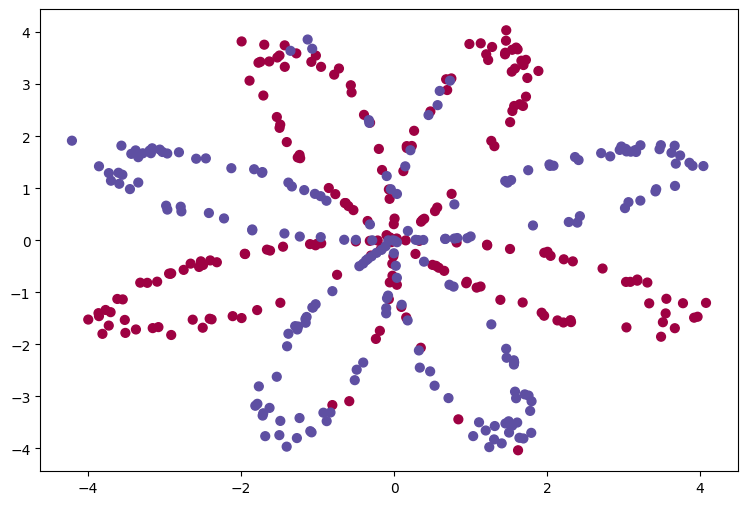

In [46]:
# Load the dataset and visualize in a 2D plot
X, Y = load_planar_dataset()

# Visualize the data:
plt.figure(figsize=(9, 6))
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);

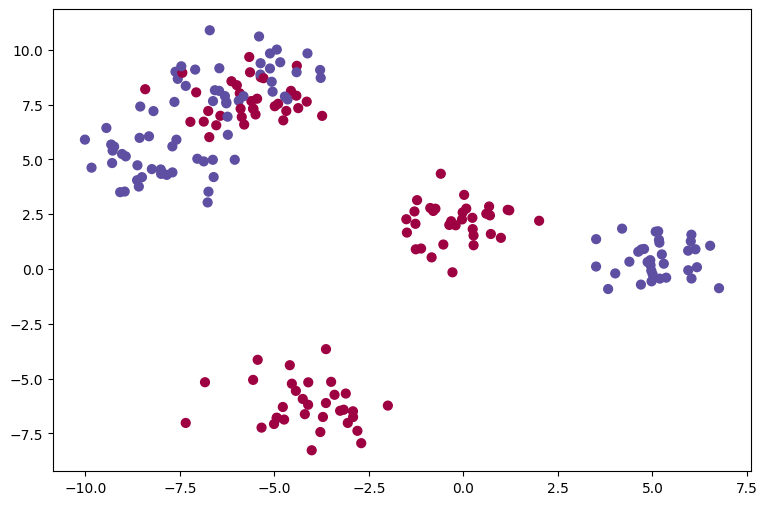

In [47]:
# Extra Datasets: Run this if you want to work with the extra datasets
noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()

datasets = {"noisy_circles": noisy_circles,
            "noisy_moons": noisy_moons,
            "blobs": blobs,
            "gaussian_quantiles": gaussian_quantiles}

# (choose your dataset)
dataset = "blobs"

X, Y = datasets[dataset]
X, Y = X.T, Y.reshape(1, Y.shape[0])

# make blobs binary
if dataset == "blobs":
    Y = Y%2

# Visualize the data
plt.figure(figsize=(9, 6))
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);

In [48]:
shape_X = X.shape
shape_Y = Y.shape
m = (X.size)/shape_X[0]  # training set size


print ('The shape of X is: ' + str(shape_X))
print ('The shape of Y is: ' + str(shape_Y))
print ('I have m = %d training examples!' % (m))

The shape of X is: (2, 200)
The shape of Y is: (1, 200)
I have m = 200 training examples!


In [49]:
# Train the logistic regression classifier
clf = sklearn.linear_model.LogisticRegressionCV();
clf.fit(X.T, Y.T.reshape(-1));

<ipython-input-52-df7c6bdb6ec1>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print ('Accuracy of logistic regression: %d ' % float((np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions))/float(Y.size)*100) +


Accuracy of logistic regression: 60 % (percentage of correctly labelled datapoints)


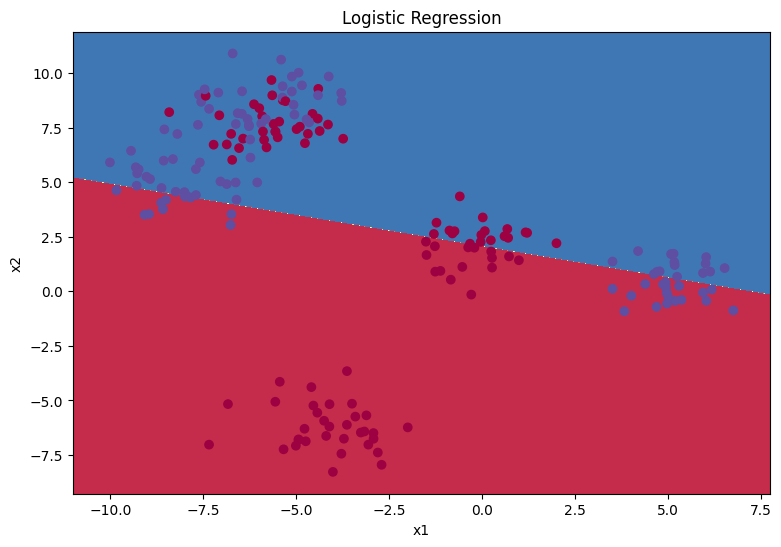

In [52]:
# Plot the decision boundary for logistic regression
plot_decision_boundary(lambda x: clf.predict(x), X, Y)
plt.title("Logistic Regression")

# Print accuracy
LR_predictions = clf.predict(X.T)
print ('Accuracy of logistic regression: %d ' % float((np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions))/float(Y.size)*100) +
       '% ' + "(percentage of correctly labelled datapoints)")

In [53]:
def predictor(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X

    Arguments:
    parameters -- python dictionary containing your parameters
    X -- input data of size (n_x, m)

    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """

    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    A2, _ = forward_propagation(X, parameters)
    predictions = (A2 > 0.5)

    return predictions

Cost after iteration 0: 1.873434
Cost after iteration 100: 0.386179
Cost after iteration 200: 0.361434
Cost after iteration 300: 0.345447
Cost after iteration 400: 0.333475
Cost after iteration 500: 0.324023
Cost after iteration 600: 0.317150
Cost after iteration 700: 0.311704
Cost after iteration 800: 0.305441
Cost after iteration 900: 0.301791
Cost after iteration 1000: 0.298136
Cost after iteration 1100: 0.294523
Cost after iteration 1200: 0.292053
Cost after iteration 1300: 0.287413
Cost after iteration 1400: 0.285512
Cost after iteration 1500: 0.283593
Cost after iteration 1600: 0.281661
Cost after iteration 1700: 0.279587
Cost after iteration 1800: 0.277742
Cost after iteration 1900: 0.275572
Cost after iteration 2000: 0.272545
Cost after iteration 2100: 0.272367
Cost after iteration 2200: 0.271083
Cost after iteration 2300: 0.267565
Cost after iteration 2400: 0.266978
Cost after iteration 2500: 0.265087
Cost after iteration 2600: 0.264215
Cost after iteration 2700: 0.263440
Cost

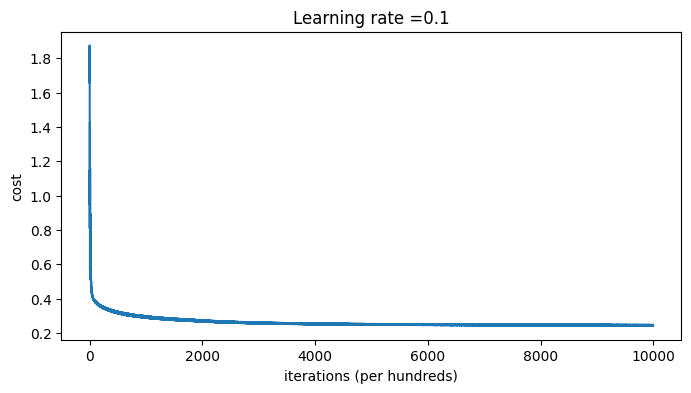

Text(0.5, 1.0, 'Decision Boundary for hidden layer size 20')

<Figure size 900x600 with 0 Axes>

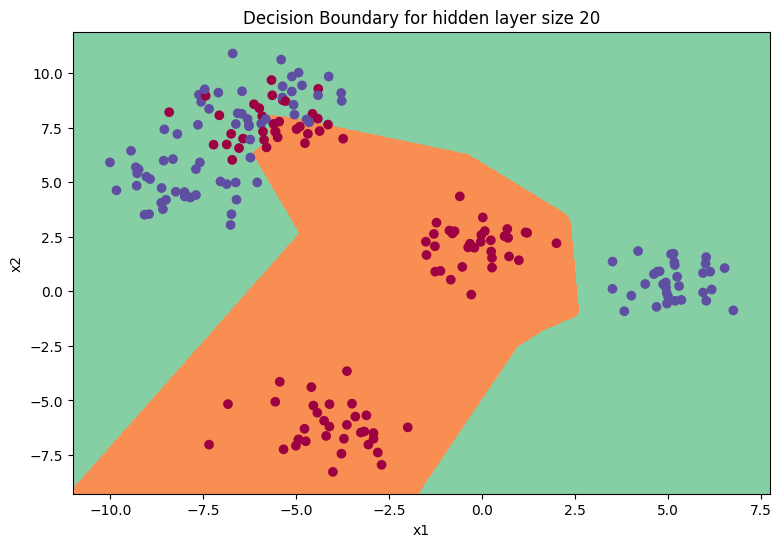

In [54]:
# Build a model with a n_h-dimensional hidden layer

h = 20
plt.figure(figsize=(8, 4))
parameters = L_layer_model(X, Y, [2, h, 1], learning_rate = 0.1 , num_iterations = 10000, print_cost = True)

# Plot the decision boundary
plt.figure(figsize=(9, 6))
plot_decision_boundary(lambda x: predictor(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(h))

Cost after iteration 0: 0.798360
Cost after iteration 100: 0.710592
Cost after iteration 200: 0.694577
Cost after iteration 300: 0.692208
Cost after iteration 400: 0.691870
Cost after iteration 500: 0.691822
Cost after iteration 600: 0.691815
Cost after iteration 700: 0.691814
Cost after iteration 800: 0.691814
Cost after iteration 900: 0.691814
Cost after iteration 1000: 0.691814
Cost after iteration 1100: 0.691814
Cost after iteration 1200: 0.691814
Cost after iteration 1300: 0.691814
Cost after iteration 1400: 0.691814
Cost after iteration 1500: 0.691814
Cost after iteration 1600: 0.691814
Cost after iteration 1700: 0.691814
Cost after iteration 1800: 0.691814
Cost after iteration 1900: 0.691814
Cost after iteration 2000: 0.691814
Cost after iteration 2100: 0.691814
Cost after iteration 2200: 0.691814
Cost after iteration 2300: 0.691814
Cost after iteration 2400: 0.691814
Cost after iteration 2500: 0.691814
Cost after iteration 2600: 0.691814
Cost after iteration 2700: 0.691814
Cost

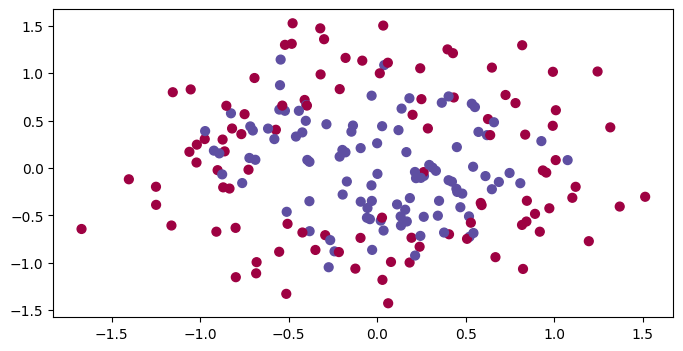

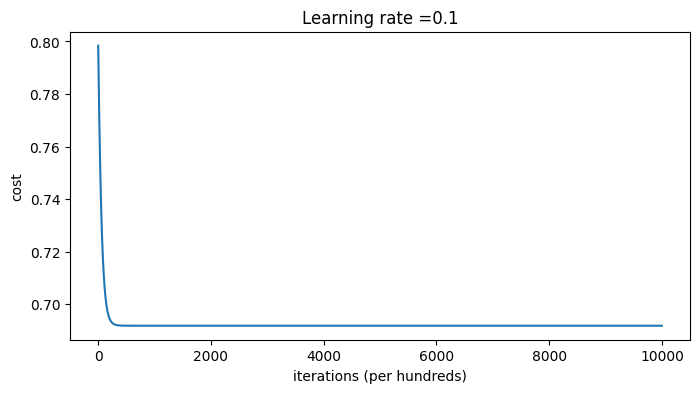

Cost after iteration 0: 0.713363
Cost after iteration 100: 0.681724
Cost after iteration 200: 0.668075
Cost after iteration 300: 0.658964
Cost after iteration 400: 0.651209
Cost after iteration 500: 0.644275
Cost after iteration 600: 0.637871
Cost after iteration 700: 0.631831
Cost after iteration 800: 0.626044
Cost after iteration 900: 0.620325
Cost after iteration 1000: 0.614658
Cost after iteration 1100: 0.609289
Cost after iteration 1200: 0.604001
Cost after iteration 1300: 0.599152
Cost after iteration 1400: 0.594616
Cost after iteration 1500: 0.590223
Cost after iteration 1600: 0.586041
Cost after iteration 1700: 0.582016
Cost after iteration 1800: 0.578059
Cost after iteration 1900: 0.574153
Cost after iteration 2000: 0.570269
Cost after iteration 2100: 0.566408
Cost after iteration 2200: 0.562529
Cost after iteration 2300: 0.558677
Cost after iteration 2400: 0.554873
Cost after iteration 2500: 0.550896
Cost after iteration 2600: 0.547007
Cost after iteration 2700: 0.543204
Cost

<Figure size 800x400 with 0 Axes>

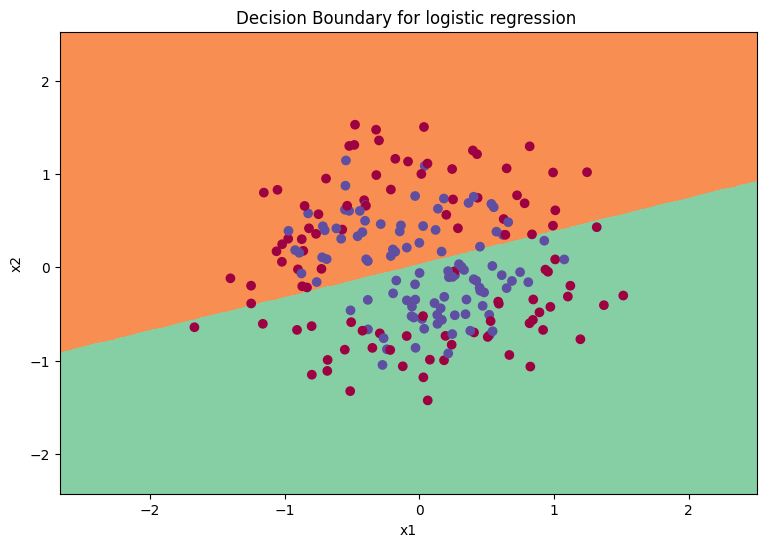

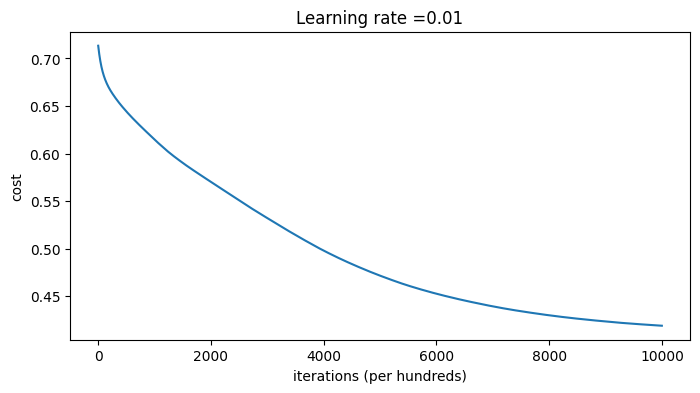

Text(0.5, 1.0, 'Decision Boundary for hidden layer size 20')

<Figure size 900x600 with 0 Axes>

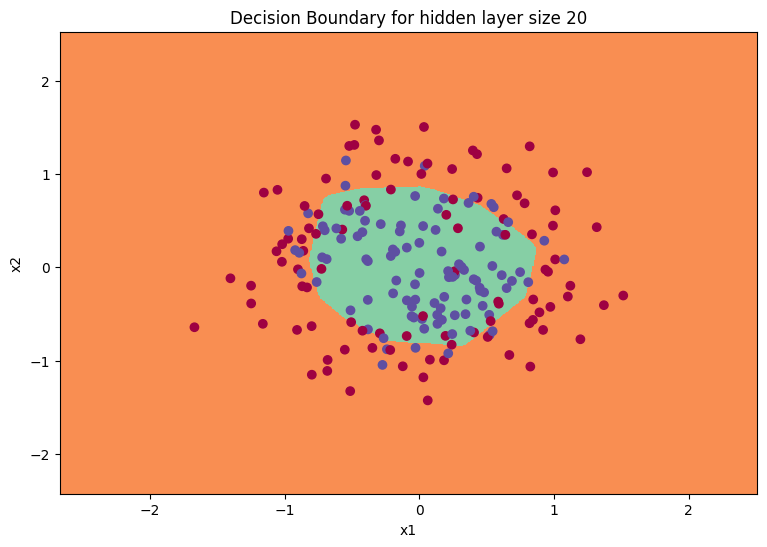

In [58]:
# Extra Datasets: Run this if you want to work with the extra datasets
noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()

datasets = {"noisy_circles": noisy_circles,
            "noisy_moons": noisy_moons,
            "blobs": blobs,
            "gaussian_quantiles": gaussian_quantiles}

# Choose your dataset
dataset = "noisy_circles"


X, Y = datasets[dataset]
X, Y = X.T, Y.reshape(1, Y.shape[0])

# make blobs binary
if dataset == "blobs":
    Y = Y%2

# Visualize the data
plt.figure(figsize=(8, 4))
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);

# Build a logistic regression model

plt.figure(figsize=(8, 4))
parameters = L_layer_model(X, Y, [2, 1], learning_rate = 0.1 , num_iterations = 10000)

# Plot the decision boundary
plt.figure(figsize=(8, 4))
plot_decision_boundary(lambda x: predictor(parameters, x.T), X, Y)
plt.title("Decision Boundary for logistic regression ")

# Build a model with a n_h-dimensional hidden layer
h = 20
plt.figure(figsize=(8,4))
parameters = L_layer_model(X, Y, [2, h, 1], learning_rate = 0.01 , num_iterations = 10000)

# Plot the decision boundary
plt.figure(3, figsize=(9, 6))
plot_decision_boundary(lambda x: predictor(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(h))

Cost after iteration 0: 0.887144
Cost after iteration 100: 0.437335
Cost after iteration 200: 0.365591
Cost after iteration 300: 0.334778
Cost after iteration 400: 0.316982
Cost after iteration 500: 0.305440
Cost after iteration 600: 0.297493
Cost after iteration 700: 0.291810
Cost after iteration 800: 0.287630
Cost after iteration 900: 0.284488
Cost after iteration 1000: 0.282081
Cost after iteration 1100: 0.280211
Cost after iteration 1200: 0.278738
Cost after iteration 1300: 0.277565
Cost after iteration 1400: 0.276622
Cost after iteration 1500: 0.275858
Cost after iteration 1600: 0.275234
Cost after iteration 1700: 0.274722
Cost after iteration 1800: 0.274299
Cost after iteration 1900: 0.273948
Cost after iteration 2000: 0.273656
Cost after iteration 2100: 0.273411
Cost after iteration 2200: 0.273206
Cost after iteration 2300: 0.273033
Cost after iteration 2400: 0.272887
Cost after iteration 2500: 0.272763
Cost after iteration 2600: 0.272658
Cost after iteration 2700: 0.272569
Cost

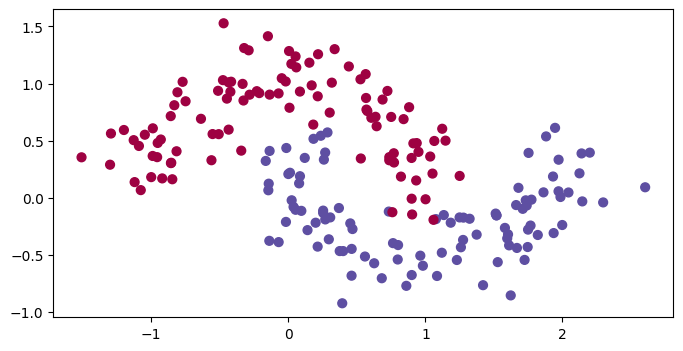

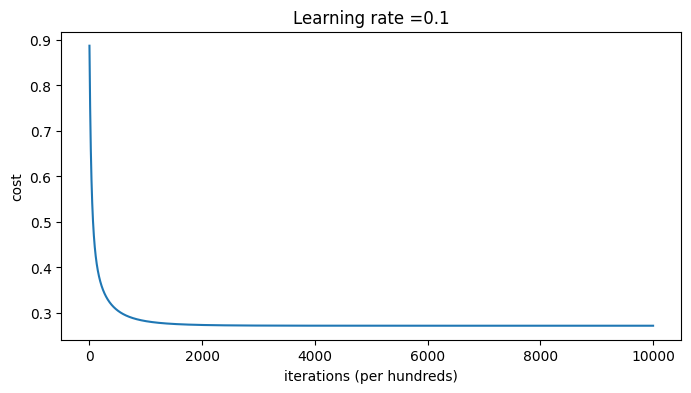

Cost after iteration 0: 0.689121
Cost after iteration 100: 0.528103
Cost after iteration 200: 0.448647
Cost after iteration 300: 0.401824
Cost after iteration 400: 0.370425
Cost after iteration 500: 0.348192
Cost after iteration 600: 0.331982
Cost after iteration 700: 0.319810
Cost after iteration 800: 0.310305
Cost after iteration 900: 0.302929
Cost after iteration 1000: 0.297114
Cost after iteration 1100: 0.292450
Cost after iteration 1200: 0.288492
Cost after iteration 1300: 0.285088
Cost after iteration 1400: 0.282178
Cost after iteration 1500: 0.279645
Cost after iteration 1600: 0.277411
Cost after iteration 1700: 0.275350
Cost after iteration 1800: 0.273342
Cost after iteration 1900: 0.271478
Cost after iteration 2000: 0.269785
Cost after iteration 2100: 0.268137
Cost after iteration 2200: 0.266582
Cost after iteration 2300: 0.265125
Cost after iteration 2400: 0.263721
Cost after iteration 2500: 0.262402
Cost after iteration 2600: 0.261147
Cost after iteration 2700: 0.259934
Cost

<Figure size 800x400 with 0 Axes>

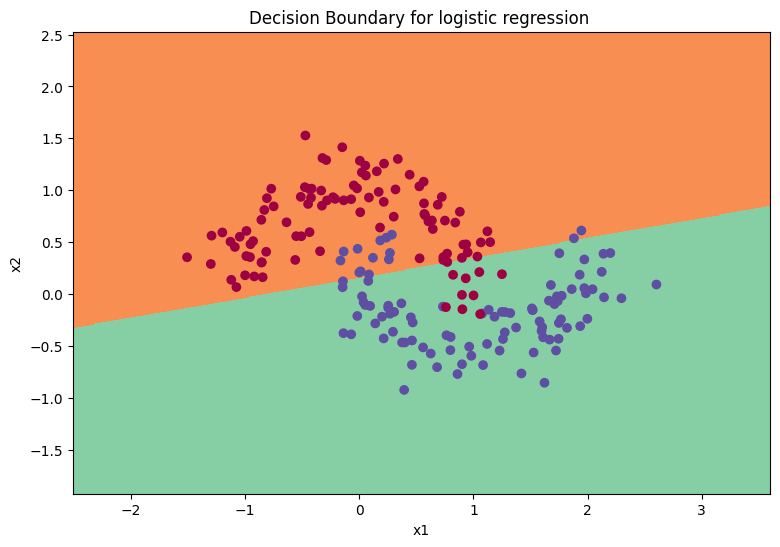

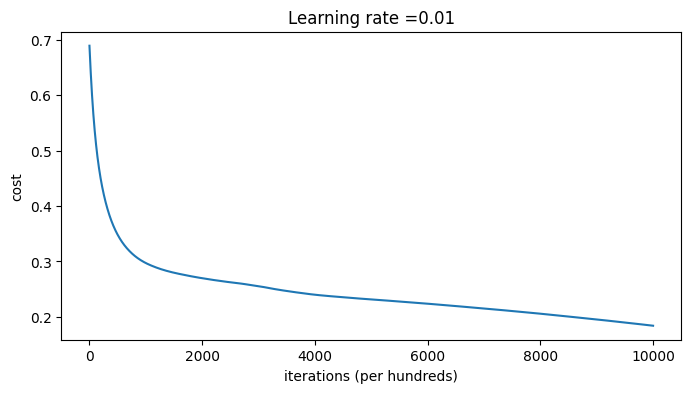

Text(0.5, 1.0, 'Decision Boundary for hidden layer size 20')

<Figure size 900x600 with 0 Axes>

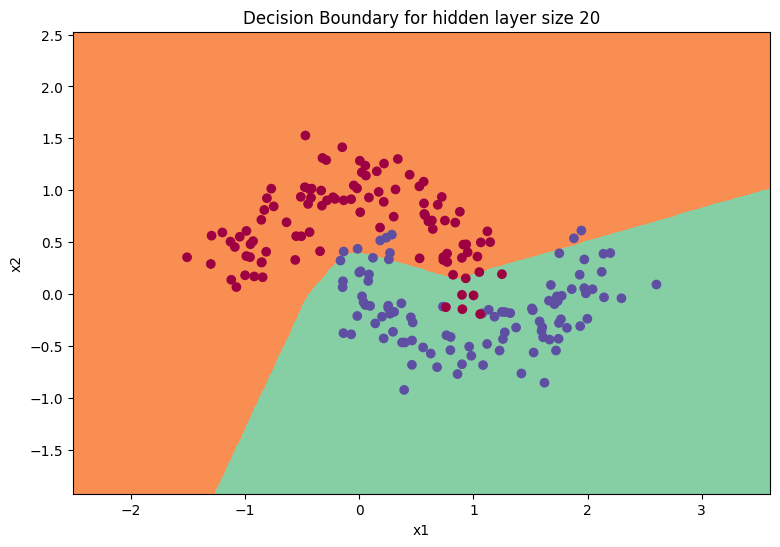

In [59]:
# Extra Datasets: Run this if you want to work with the extra datasets
noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()

datasets = {"noisy_circles": noisy_circles,
            "noisy_moons": noisy_moons,
            "blobs": blobs,
            "gaussian_quantiles": gaussian_quantiles}

# Choose your dataset
dataset = "noisy_moons"


X, Y = datasets[dataset]
X, Y = X.T, Y.reshape(1, Y.shape[0])

# make blobs binary
if dataset == "blobs":
    Y = Y%2

# Visualize the data
plt.figure(figsize=(8, 4))
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);

# Build a logistic regression model

plt.figure(figsize=(8, 4))
parameters = L_layer_model(X, Y, [2, 1], learning_rate = 0.1 , num_iterations = 10000)

# Plot the decision boundary
plt.figure(figsize=(8, 4))
plot_decision_boundary(lambda x: predictor(parameters, x.T), X, Y)
plt.title("Decision Boundary for logistic regression ")

# Build a model with a n_h-dimensional hidden layer
h = 20
plt.figure(figsize=(8,4))
parameters = L_layer_model(X, Y, [2, h, 1], learning_rate = 0.01 , num_iterations = 10000)

# Plot the decision boundary
plt.figure(3, figsize=(9, 6))
plot_decision_boundary(lambda x: predictor(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(h))

Cost after iteration 0: 0.754444
Cost after iteration 100: 0.694799
Cost after iteration 200: 0.690066
Cost after iteration 300: 0.689707
Cost after iteration 400: 0.689679
Cost after iteration 500: 0.689677
Cost after iteration 600: 0.689677
Cost after iteration 700: 0.689677
Cost after iteration 800: 0.689677
Cost after iteration 900: 0.689677
Cost after iteration 1000: 0.689677
Cost after iteration 1100: 0.689677
Cost after iteration 1200: 0.689677
Cost after iteration 1300: 0.689677
Cost after iteration 1400: 0.689677
Cost after iteration 1500: 0.689677
Cost after iteration 1600: 0.689677
Cost after iteration 1700: 0.689677
Cost after iteration 1800: 0.689677
Cost after iteration 1900: 0.689677
Cost after iteration 2000: 0.689677
Cost after iteration 2100: 0.689677
Cost after iteration 2200: 0.689677
Cost after iteration 2300: 0.689677
Cost after iteration 2400: 0.689677
Cost after iteration 2500: 0.689677
Cost after iteration 2600: 0.689677
Cost after iteration 2700: 0.689677
Cost

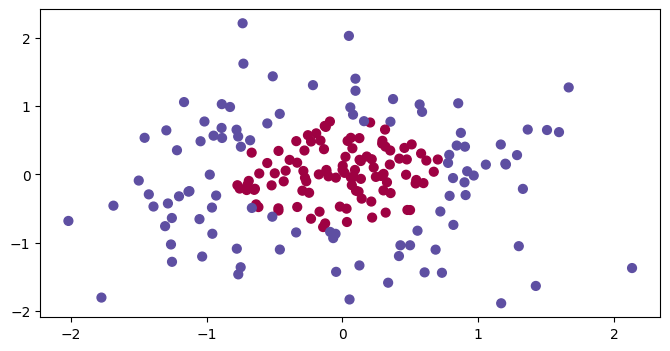

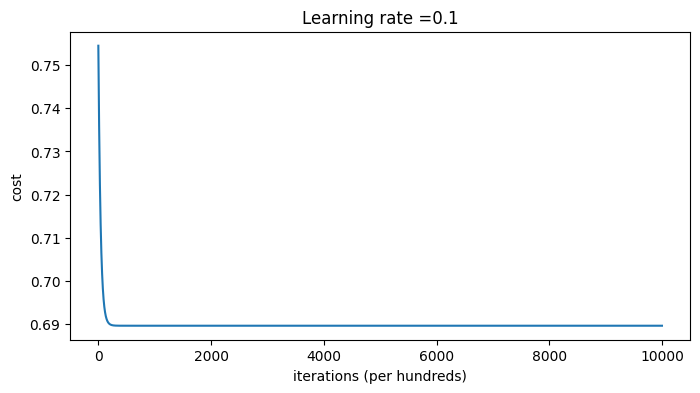

Cost after iteration 0: 0.792187
Cost after iteration 100: 0.674185
Cost after iteration 200: 0.623023
Cost after iteration 300: 0.590473
Cost after iteration 400: 0.564606
Cost after iteration 500: 0.542274
Cost after iteration 600: 0.522431
Cost after iteration 700: 0.504385
Cost after iteration 800: 0.487695
Cost after iteration 900: 0.472220
Cost after iteration 1000: 0.457702
Cost after iteration 1100: 0.443885
Cost after iteration 1200: 0.430785
Cost after iteration 1300: 0.418340
Cost after iteration 1400: 0.406441
Cost after iteration 1500: 0.395033
Cost after iteration 1600: 0.384117
Cost after iteration 1700: 0.373674
Cost after iteration 1800: 0.363464
Cost after iteration 1900: 0.353604
Cost after iteration 2000: 0.344144
Cost after iteration 2100: 0.335127
Cost after iteration 2200: 0.326540
Cost after iteration 2300: 0.318339
Cost after iteration 2400: 0.310535
Cost after iteration 2500: 0.303123
Cost after iteration 2600: 0.296060
Cost after iteration 2700: 0.289376
Cost

<Figure size 800x400 with 0 Axes>

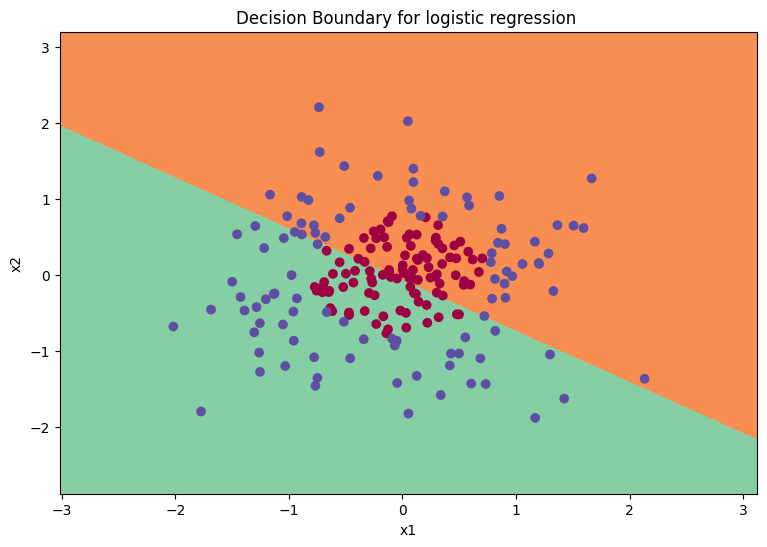

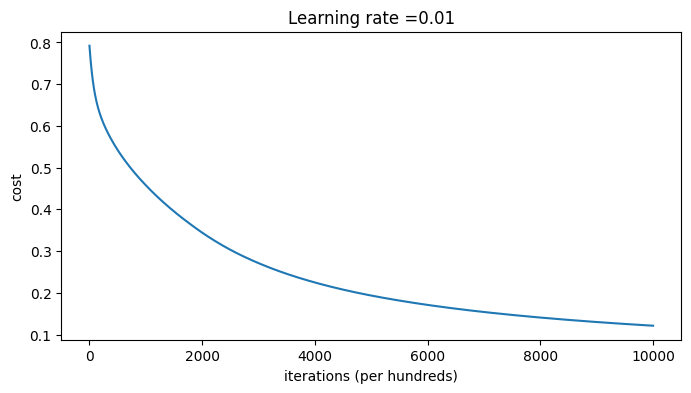

Text(0.5, 1.0, 'Decision Boundary for hidden layer size 20')

<Figure size 900x600 with 0 Axes>

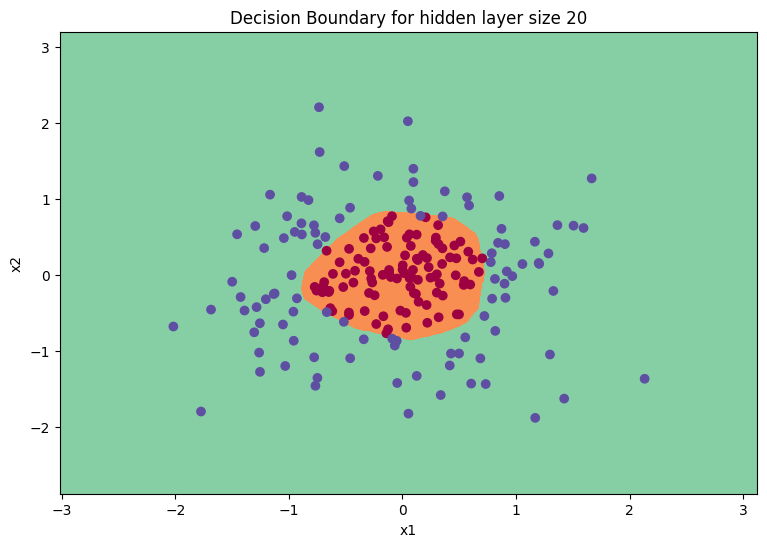

In [60]:
# Extra Datasets: Run this if you want to work with the extra datasets
noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()

datasets = {"noisy_circles": noisy_circles,
            "noisy_moons": noisy_moons,
            "blobs": blobs,
            "gaussian_quantiles": gaussian_quantiles}

# Choose your dataset
dataset = "gaussian_quantiles"


X, Y = datasets[dataset]
X, Y = X.T, Y.reshape(1, Y.shape[0])

# make blobs binary
if dataset == "blobs":
    Y = Y%2

# Visualize the data
plt.figure(figsize=(8, 4))
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);

# Build a logistic regression model

plt.figure(figsize=(8, 4))
parameters = L_layer_model(X, Y, [2, 1], learning_rate = 0.1 , num_iterations = 10000)

# Plot the decision boundary
plt.figure(figsize=(8, 4))
plot_decision_boundary(lambda x: predictor(parameters, x.T), X, Y)
plt.title("Decision Boundary for logistic regression ")

# Build a model with a n_h-dimensional hidden layer
h = 20
plt.figure(figsize=(8,4))
parameters = L_layer_model(X, Y, [2, h, 1], learning_rate = 0.01 , num_iterations = 10000)

# Plot the decision boundary
plt.figure(3, figsize=(9, 6))
plot_decision_boundary(lambda x: predictor(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(h))